In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle

import tensorflow as tf 
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
#Dataset from: http://files.grouplens.org/datasets/movielens/ml-20m.zip
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [3]:
#Assigning integer encodings to userId and movieId(since we're going to be using embeddings)
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [5]:
user_ids = df['new_user_id'].to_numpy()
movie_ids = df['new_movie_id'].to_numpy()
ratings = df['rating'].to_numpy()

In [6]:
N = len(set(user_ids))
M = len(set(movie_ids))
K = 10 #Embedding dimension

In [7]:
#User input:
u = Input(shape = (1,))
#Movie input:
m = Input(shape = (1,))
#User embedding:
u_emb = Embedding(N, K)(u)
#Movie embedding:
m_emb = Embedding(M, K)(m)
#Output of embeddings is NxTxK, here T = 1, so Nx1xD. We flatten this to NxK
u_emb = Flatten()(u_emb)
m_emb = Flatten()(m_emb)
#Concat user-movie embeddings to a feature vector
x = Concatenate()([u_emb, m_emb]) #Output is Nx2K
x = Dense(1024, activation = 'relu')(x)
x = Dense(1)(x)

model = Model(inputs = [u, m], outputs = x)

In [8]:
model.compile(
    loss = 'mse',
    optimizer = SGD(learning_rate = 0.08, momentum = 0.9)
)

In [9]:
#Split the data:
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings) #Shuffles data from arrays randomly but correspondingly.
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

#Centre the ratings:
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating
#If you want to scale ratings with std deviation, mse loss will change, so comparison with other techniques would require you to scale back the data.

In [11]:
r = model.fit(
    x = [train_user, train_movie],
    y = train_ratings,
    epochs = 25,
    batch_size = 1024,
    verbose = 2,
    validation_data = ([test_user, test_movie], test_ratings)
)

Epoch 1/25
15626/15626 - 68s - loss: 0.7773 - val_loss: 0.7248 - 68s/epoch - 4ms/step
Epoch 2/25
15626/15626 - 65s - loss: 0.7010 - val_loss: 0.6971 - 65s/epoch - 4ms/step
Epoch 3/25
15626/15626 - 65s - loss: 0.6778 - val_loss: 0.6835 - 65s/epoch - 4ms/step
Epoch 4/25
15626/15626 - 66s - loss: 0.6624 - val_loss: 0.6793 - 66s/epoch - 4ms/step
Epoch 5/25
15626/15626 - 65s - loss: 0.6514 - val_loss: 0.6711 - 65s/epoch - 4ms/step
Epoch 6/25
15626/15626 - 65s - loss: 0.6397 - val_loss: 0.6643 - 65s/epoch - 4ms/step
Epoch 7/25
15626/15626 - 65s - loss: 0.6259 - val_loss: 0.6500 - 65s/epoch - 4ms/step
Epoch 8/25
15626/15626 - 65s - loss: 0.6109 - val_loss: 0.6442 - 65s/epoch - 4ms/step
Epoch 9/25
15626/15626 - 67s - loss: 0.6002 - val_loss: 0.6401 - 67s/epoch - 4ms/step
Epoch 10/25
15626/15626 - 65s - loss: 0.5912 - val_loss: 0.6361 - 65s/epoch - 4ms/step
Epoch 11/25
15626/15626 - 65s - loss: 0.5832 - val_loss: 0.6363 - 65s/epoch - 4ms/step
Epoch 12/25
15626/15626 - 65s - loss: 0.5758 - val_l

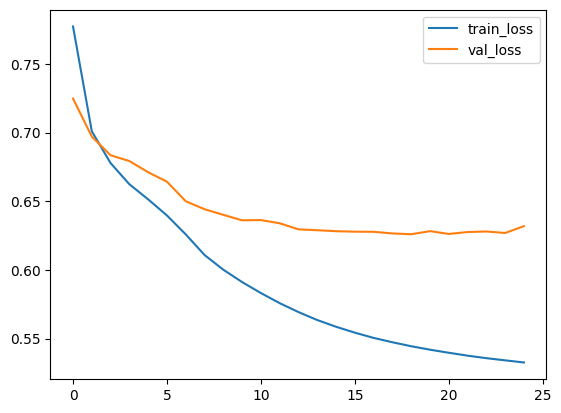

In [12]:
#Benchmark shows that results are on par with other approaches(https://datascience.stackexchange.com/questions/29740/benchmark-result-for-movielens-dataset)
plt.plot(r.history['loss'], label = 'train_loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()